In [1]:
%matplotlib inline
#
from lrgsglib.core import *
#
move_to_rootf()
plt.style.use('ipynb/nb_plotsheet.mplstyle')
#
path_suppinf = PATHPLOT / Path(PATHNPAPR, 'suppinf')
path_extras = path_suppinf / Path('extras')
path_isingXERR = path_extras / Path('isingXERR')
path_tsb = path_extras / Path('tsb')
sub_path = Path(*path_tsb.parts[1:])


Current working directory: /home/opisthofulax/PhD/projects/complex-networks/lrgsglib


## Ising XERR

In [2]:
def run_ising_dynamics(l, T, ic, out_suffix=None, thrmSTEP=50):
    ene_pat = l.path_ising / Path(f"ene_p={l.pflip:.3g}_T={T:.3g}_{out_suffix}.bin")
    sout_pat = l.path_ising / Path(f"sout_p={l.pflip:.3g}_T={T:.3g}_{out_suffix}.bin")
    if os.path.exists(ene_pat) and os.path.exists(sout_pat):
        print(f"Files {ene_pat} and {sout_pat} already exist. Skipping.", flush=True)
        return
    print(f"Running Ising dynamics for T={T:.3g} and ic={ic}")
    isdy = IsingDynamics(l, T=T, ic=ic, runlang='C3', rndStr=True, 
                         out_suffix=out_suffix)
    isdy.init_ising_dynamics()
    l.export_edgel_bin(exName=isdy.id_string_isingdyn)
    isdy.run(thrmSTEP=thrmSTEP)
    isdy.remove_run_c_files()

In [3]:
side = 32
geo = 'sqr'
cell = 'randXERR'
pflip = 0.2
T = 0.75

In [4]:
which_l = [0, 1, 2, 3, 4]

In [5]:
l = Lattice2D(side, geo, pflip=pflip, init_nw_dict=True, 
              path_data=path_isingXERR)
l.flip_sel_edges(l.nwDict[cell]['G'])
l.compute_k_eigvV(np.max(which_l)+1)

In [6]:
out_suffixes = ['uniform']
run_ising_dynamics(l, T, ic=f'uniform', out_suffix=out_suffixes[0], thrmSTEP=100)
for w in which_l:
    out_suffixes.append(f'gs_{w}')
    run_ising_dynamics(l, T, ic=f'ground_state_{w}', out_suffix=f'gs_{w}', thrmSTEP=100)

Running Ising dynamics for T=0.75 and ic=uniform
Running Ising dynamics for T=0.75 and ic=ground_state_0
Running Ising dynamics for T=0.75 and ic=ground_state_1
Running Ising dynamics for T=0.75 and ic=ground_state_2
Running Ising dynamics for T=0.75 and ic=ground_state_3
Running Ising dynamics for T=0.75 and ic=ground_state_4


In [7]:
ene = {osx: np.fromfile((
            l.path_ising /
            Path(f"ene_p={pflip:.3g}_T={T:.3g}_{osx}.bin")
        )) for osx in out_suffixes}
s_l = {osx: np.fromfile((
            l.path_ising /
            Path(f"sout_p={pflip:.3g}_T={T:.3g}_{osx}.bin")
        ), dtype=np.int8) for osx in out_suffixes}


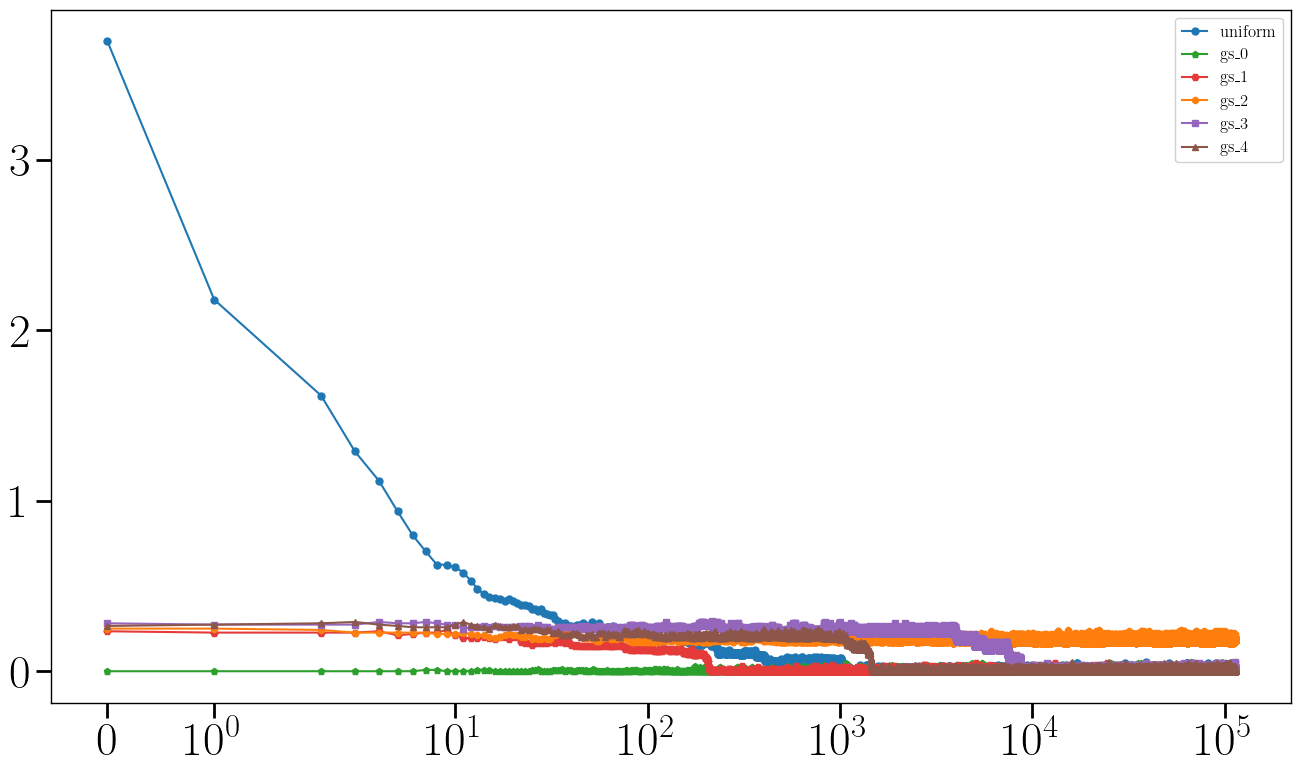

In [8]:
min_value = min([np.min(arr) for arr in ene.values()])

for i,(k, v) in enumerate(ene.items()):
    plt.plot(v-min_value, label=k)
plt.xscale('symlog')
# 
plt.legend()

### Degeneracy in action

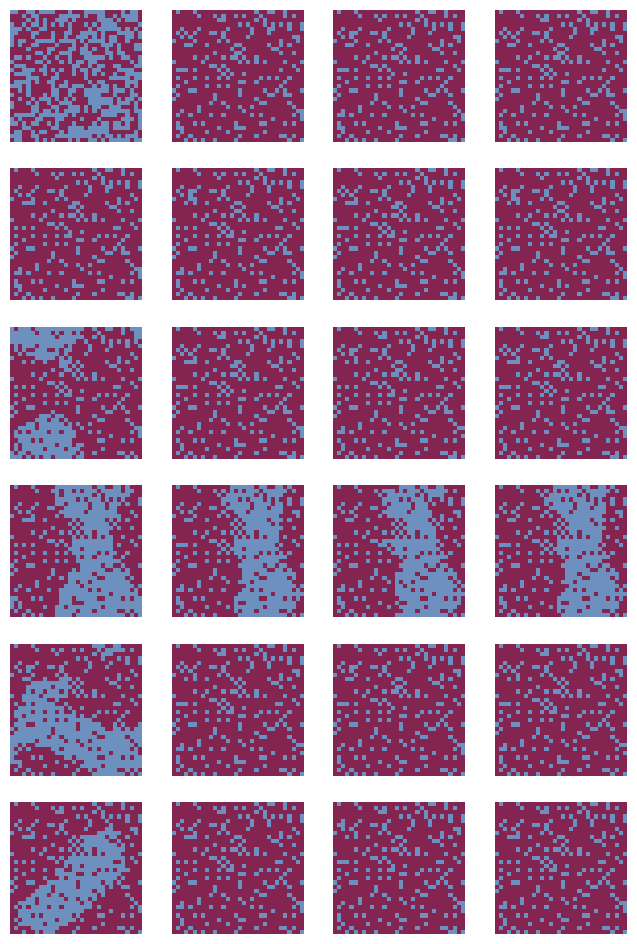

In [9]:
fig, ax = plt.subplots(len(ene), 4, figsize=(4*2, len(ene)*2))
kw_args = dict(interpolation='none', cmap=credcblu)

for i,(k, v) in enumerate(ene.items()):
    if i == 0:
        ax[i,0].imshow(np.random.choice([-1, 1], size=l.N).reshape(*l.syshape), **kw_args)
    else:
        ax[i,0].imshow(l.get_eigV_bin_check(which_l[i-1]).reshape(*l.syshape), **kw_args)
    states = s_l[k].reshape(-1, *l.syshape)
    ax[i,1].imshow(flip_to_positive_majority_adapted(states[-len(states)//10]), **kw_args)
    ax[i,2].imshow(flip_to_positive_majority_adapted(states[-len(states)//2]), **kw_args)
    ax[i,3].imshow(flip_to_positive_majority_adapted(states[-1]), **kw_args)
    for axx in ax[i]:
        axx.axis('off')
fig.savefig(path_isingXERR / Path(f"isingXERR_{l.geo}_{l.N}_T={T:.3g}_p={pflip:.3g}.pdf"),
             bbox_inches='tight', transparent=True)

## Topological Symmetry Breaking
Plots to do:
- one showing the disappearance of the microscopic peak with $N$
- one with big size with the states on it
- one with $P(\lambda/\lambda_0)$

In [46]:
size = 64
navg = 5000
geo = 'sqr'
cell = 'rand'
pflip_l = [0.01, 0.05, 0.1, 0.15, 0.5]

In [130]:
hist_data = {}
for pflip in pflip_l:
    hist_data[pflip] = []
    l_test = Lattice2D(size, geo, pflip=pflip, path_data=path_tsb)
    data_path = l_test.path_spect / Path(f"dist_eigval_{pflip:.3g}_{cell}_{navg}.pkl")
    if not os.path.exists(data_path):
        continue
    hist_data[pflip] = pk.load(open(data_path, 'rb'))

In [184]:
pflip = pflip_l[1]

In [185]:
x, y = np.array(list(hist_data[pflip].keys())), np.array(list(hist_data[pflip].values()))
x_idx = np.argsort(x)
x, y = x[x_idx], y[x_idx]
def rebin_hist(x, y, new_bins):
    """
    x: bin centers (sorted 1D array)
    y: bin counts (same shape as x)
    new_bins: number of bins to reduce to
    """
    # Ensure x is sorted:
    sort_idx = np.argsort(x)
    x, y = x[sort_idx], y[sort_idx]
    
    # Create new bin edges (we keep the original data range)
    edges = np.linspace(x[0], x[-1], new_bins + 1)
    
    # Prepare arrays for the new histogram
    new_x = np.zeros(new_bins)
    new_y = np.zeros(new_bins)
    
    # Fill the new bins
    for i in range(new_bins):
        # Include the rightmost edge in the last bin
        if i < new_bins - 1:
            mask = (x >= edges[i]) & (x < edges[i + 1])
        else:
            mask = (x >= edges[i]) & (x <= edges[i + 1])
        
        x_in_bin = x[mask]
        y_in_bin = y[mask]
        
        # If no values fall into this bin, pick a midpoint for new_x
        if len(x_in_bin) == 0:
            new_x[i] = 0.5 * (edges[i] + edges[i + 1])
            new_y[i] = 0
        else:
            # Weighted average for new bin center
            new_x[i] = np.average(x_in_bin, weights=y_in_bin)
            new_y[i] = np.sum(y_in_bin)
    
    return new_x, new_y
x,y = rebin_hist(x, y, 200)

In [186]:
# Apply median filter with a window size (odd number)
filtered_signal = medfilt(y, kernel_size=3)  # Adjust kernel_size for stronger filtering
filtered_signal = gaussian_filter1d(y, sigma=2)

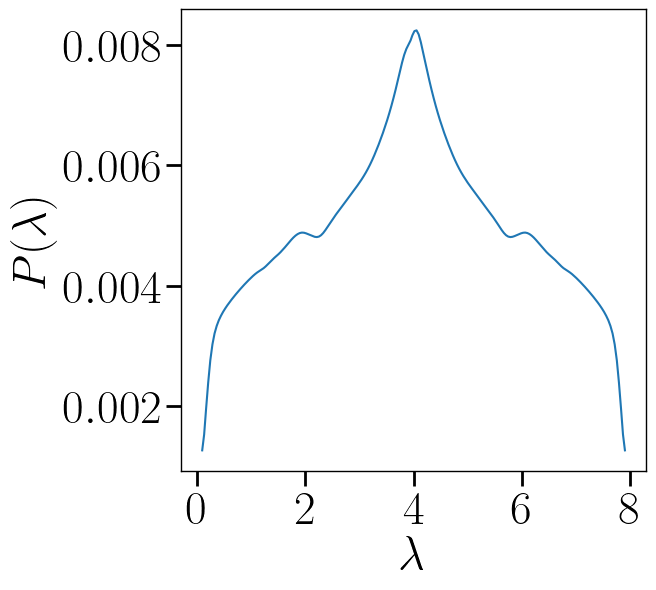

In [187]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(x, filtered_signal/np.sum(filtered_signal), '-')
# ax.set_yticks([])
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$P(\lambda)$')
ax.set_xticks(np.arange(int(np.min(x)), int(np.max(x)+2), 2));
# ax.text(0.05, 0.9, r'\textbf{(a)}', transform=ax.transAxes)


In [120]:
pflip_l

[0.01, 0.05, 0.1, 0.15, 0.5]

In [42]:
l = Lattice2D(size, geo, pflip=pflip)
l.flip_random_fract_edges()
l.compute_laplacian_spectrum()

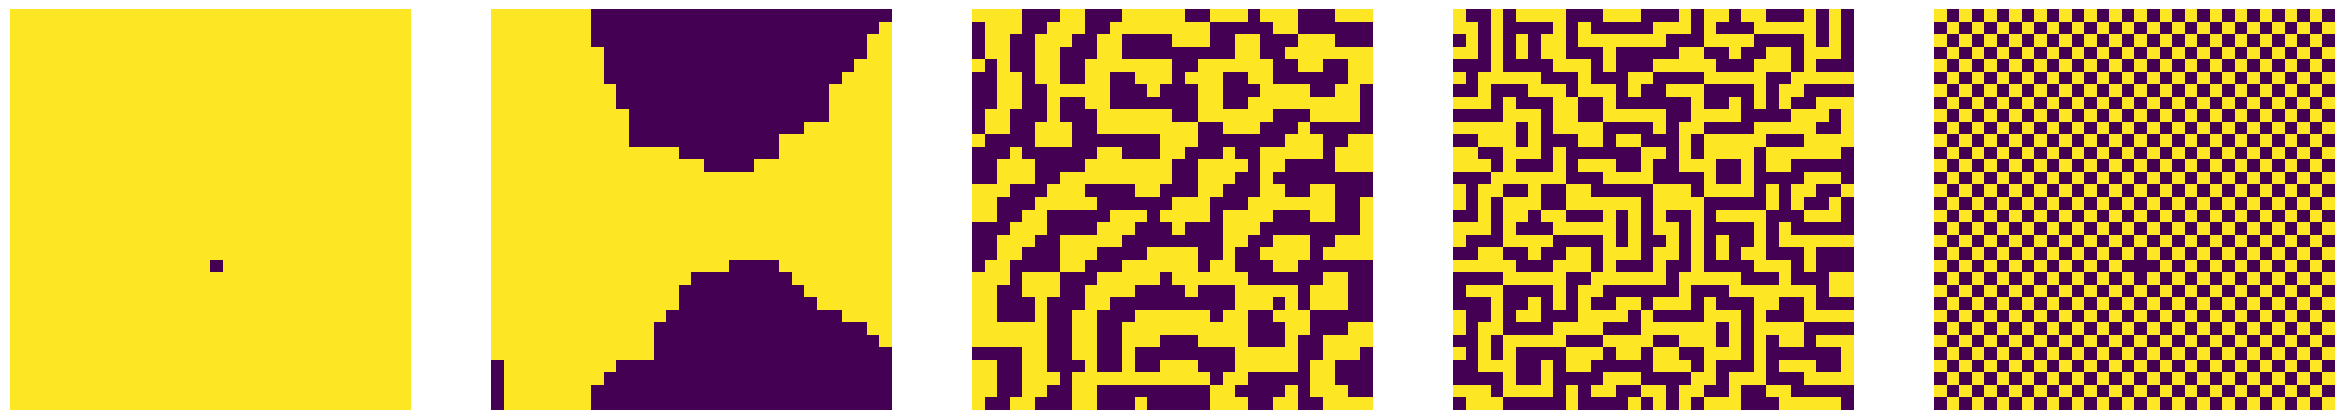

In [43]:
fig, ax = plt.subplots(1, len(pflip_l), figsize=(6*len(pflip_l), 6))
for i, eign in enumerate([0, 1, l.N//5, l.N//2, l.N-1]):
    ax[i].imshow(l.get_eigV_bin_check(eign).reshape(*l.syshape))
    ax[i].axis('off')